<a href="https://colab.research.google.com/github/Nord-ouest-Advisors/InvestGuard/blob/main/InvestGuard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json

Functions to compute financial quantities

In [4]:
def daily_returns(data):
    """Returns DataFrame with daily returns (percentage change)
    :math:`\\displaystyle R = \\dfrac{\\text{price}_{t_i} - \\text{price}_{t_{i-1}}}{\\text{price}_{t_{i-1}}}`
    :Input:
     :data: ``pandas.DataFrame`` with daily stock prices
    :Output:
     :ret: a ``pandas.DataFrame`` of daily percentage change of Returns
         of given stock prices.
    """
    return data.pct_change().dropna(how="all").replace([np.inf, -np.inf], np.nan)

def cumulative_returns(data, dividend=0):
    """Returns DataFrame with cumulative returns
    :math:`\\displaystyle R = \\dfrac{\\text{price}_{t_i} - \\text{price}_{t_0} + \\text{dividend}}{\\text{price}_{t_0}}`
    :Input:
     :data: ``pandas.DataFrame`` with daily stock prices
     :dividend: ``float`` (default= ``0``), paid dividend
    :Output:
     :ret: a ``pandas.DataFrame`` of cumulative Returns of given stock prices.
    """
    if isinstance(data, pd.Series):
        data = pd.DataFrame(data)
    return data.dropna(axis=0, how="any").apply(lambda x: (x - x[0] + dividend) / x[0])

def historical_mean_return(data, freq=252):
    """Returns the mean return based on historical stock price data.
    :Input:
     :data: ``pandas.DataFrame`` with daily stock prices
     :freq: ``int`` (default= ``252``), number of trading days, default
             value corresponds to trading days in a year
    :Output:
     :ret: a ``pandas.DataFrame`` of historical mean Returns.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("data must be a pandas.DataFrame")
    return daily_returns(data).mean() * freq

def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})
    
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns


def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5    

def weighted_mean(means, weights):
    """Computes the weighted mean/average, or in the case of a
    financial portfolio, it can be used for the Expected Return
    of said portfolio.
    :Input:
     :means: ``numpy.ndarray``/``pd.Series`` of mean/average values
     :weights: ``numpy.ndarray``/``pd.Series`` of weights
    :Output:
     :weighted mu: ``numpy.ndarray``: ``(np.sum(means*weights))``
    """
    if not isinstance(weights, (pd.Series, np.ndarray)):
        raise ValueError("weights is expected to be a pandas.Series/np.ndarray")
    if not isinstance(means, (pd.Series, np.ndarray)):
        raise ValueError("means is expected to be a pandas.Series/np.ndarray")
    return np.sum(means * weights)


def weighted_std(cov_matrix, weights):
    """Computes the weighted standard deviation, or Volatility of
    a portfolio, which contains several stocks.
    :Input:
     :cov_matrix: ``numpy.ndarray``/``pandas.DataFrame``, covariance matrix
     :weights: ``numpy.ndarray``/``pd.Series`` of weights
    :Output:
     :weighted sigma: ``numpy.ndarray``:
         ``np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))``
    """
    if not isinstance(weights, (pd.Series, np.ndarray)):
        raise ValueError("weights is expected to be a pandas.Series, np.array")
    if not isinstance(cov_matrix, (np.ndarray, (np.ndarray, pd.DataFrame))):
        raise ValueError(
            "cov_matrix is expected to be a numpy.ndarray/pandas.DataFrame"
        )
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


def sharpe_ratio(exp_return, volatility, risk_free_rate=0.005):
    """Computes the Sharpe Ratio
    :Input:
     :exp_return: ``int``/``float``, Expected Return of a portfolio
     :volatility: ``int``/``float``, Volatility of a portfolio
     :risk_free_rate: ``int``/``float`` (default= ``0.005``), risk free rate
    :Output:
     :sharpe ratio: ``float`` ``(exp_return - risk_free_rate)/float(volatility)``
    """
    if not isinstance(
        exp_return, (int, float, np.int32, np.int64, np.float32, np.float64)
    ):
        raise ValueError("exp_return is expected to be an integer or float.")
    if not isinstance(
        volatility, (int, float, np.int32, np.int64, np.float32, np.float64)
    ):
        raise ValueError("volatility is expected to be an integer or float.")
    if not isinstance(
        risk_free_rate, (int, float, np.int32, np.int64, np.float32, np.float64)
    ):
        raise ValueError("risk_free_rate is expected to be an integer or float.")
    return (exp_return - risk_free_rate) / float(volatility)


def annualised_portfolio_quantities(weights, means, cov_matrix, risk_free_rate=0.005, freq=252):
    """Computes and returns the expected annualised return, volatility
    and Sharpe Ratio of a portfolio.
    :Input:
     :weights: ``numpy.ndarray``/``pd.Series`` of weights
     :means: ``numpy.ndarray``/``pd.Series`` of mean/average values
     :cov_matrix: ``numpy.ndarray``/``pandas.DataFrame``, covariance matrix
     :risk_free_rate: ``float`` (default= ``0.005``), risk free rate
     :freq: ``int`` (default= ``252``), number of trading days, default
         value corresponds to trading days in a year
    :Output:
     :(Expected Return, Volatility, Sharpe Ratio): tuple of those
         three quantities
    """
    if not isinstance(freq, int):
        raise ValueError("freq is expected to be an integer.")
    expected_return = weighted_mean(means, weights) * freq
    volatility = weighted_std(cov_matrix, weights) * np.sqrt(freq)
    sharpe = sharpe_ratio(expected_return, volatility, risk_free_rate)
    return (expected_return, volatility, sharpe)

In [5]:
trnx_url = 'https://raw.githubusercontent.com/Nord-ouest-Advisors/InvestGuard/main/data/SampleTransactions.csv?token=ATIZFFVOVFH4FDFT3E5JACLAY3VSA'
prices_url = 'https://raw.githubusercontent.com/Nord-ouest-Advisors/InvestGuard/main/data/Prices.csv?token=ATIZFFRAZPQAW4CE7SLEYODAY3VTY'
info_url = 'https://raw.githubusercontent.com/Nord-ouest-Advisors/InvestGuard/main/data/FundsInfo.csv?token=ATIZFFVW6AOPSMBNG473IKLAY3VV2'

In [6]:
def get_transactions(url):
    trnx = pd.read_csv(url)
    trnx['InstructionDate'] = pd.to_datetime(trnx['InstructionDate'])
    trnx.sort_values(by=['FundPortfolio','InstructionDate'], inplace=True)
    return trnx

def get_prices(url):
    prices = pd.read_csv(url)
    prices['Date'] = pd.to_datetime(prices['Date'])
    prices.sort_values(by=['FundISIN', 'Date'], inplace=True)
    prices.set_index(['Date'], inplace=True)
    prices.reset_index(inplace=True)
    return prices

def get_funds_info(url):
    info = pd.read_csv(info_url)
    info['FundNameAdj'] = info['FundName']+"("+info['Currency']+")"
    return info

def get_names_dict(url):
    info = pd.read_csv(info_url)
    info['FundNameAdj'] = info['FundName']+"("+info['Currency']+")"
    info_copy = info.copy()
    cols = ['FundISIN','FundNameAdj']
    info_copy = info_copy[cols].set_index('FundISIN')
    info_dict = {isin:info_copy.loc[isin][0] for isin in info_copy.index}
    return info_dict


In [7]:
trnx = get_transactions(trnx_url)
prices = get_prices(prices_url)
info = get_funds_info(info_url)
names = get_names_dict(info_url)

In [106]:
portfolios_dict = {portfolio:trnx[trnx['FundPortfolio']==portfolio] for portfolio in trnx['FundPortfolio'].unique()}

In [83]:
prtfl_prices_df = prtfl_prices.set_index('Date')
prtfl_prices_df = prtfl_prices_df.pivot(columns=['FundISIN']).fillna(method='ffill')
prtfl_prices_df.columns = [col[1] for col in prtfl_prices_df.columns]
prtfl_prices_df.rename(columns=names, inplace=True)
prtfl_prices_df.head()

,AMUNDI FUNDS ASIA EQUITY CONCENTRATED (EUR),AMUNDI FUNDS EMERGING WORLD EQUITY (EUR),AMUNDI FUNDS CASH EUR (EUR),AMUNDI FUNDS EMERGING EUROPE AND MEDITERRANEAN EQUITY (EUR),AMUNDI FUNDS EMERGING MARKETS BOND (EUR),AMUNDI FUNDS EUROPEAN EQUITY SMALL CAP (EUR),AMUNDI FUNDS GLOBAL ECOLOGY ESG (EUR),AMUNDI FUNDS PIONEER US EQUITY FUNDAMENTAL GROWTH (EUR),AMUNDI FUNDS PIONEER US HIGH YIELD BOND (EUR)
Date,,,,,,,,,
2012-04-17,92.15,99.10,100.66,17.34,10.50,85.86,151.91,99.34,7.55
2012-04-18,93.09,99.51,100.66,17.34,10.49,85.61,152.05,99.35,7.57
2012-04-19,93.31,99.39,100.67,17.48,10.48,85.76,151.20,98.31,7.56
2012-04-20,91.98,98.76,100.67,17.51,10.45,85.84,151.14,98.03,7.52
2012-04-21,91.98,98.76,100.67,17.51,10.45,85.84,151.14,98.03,7.52


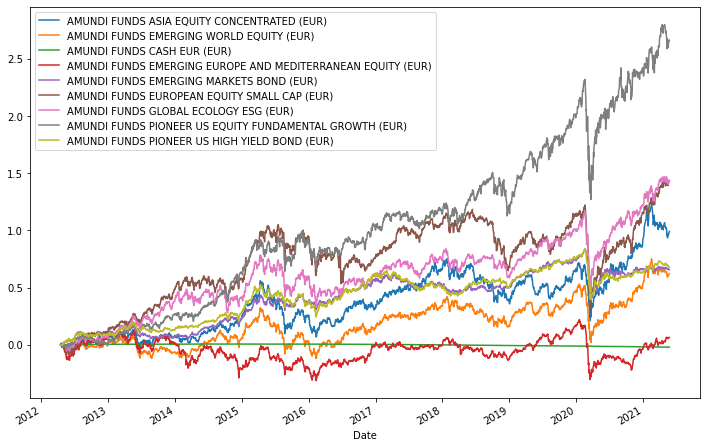

In [12]:
ax = cumulative_returns(prtfl_prices_df).plot(figsize=(12,8), legend=True)
#((1+prtfl_prices_df.pct_change()).cumprod()-1).plot(ax=ax)

In [84]:
def daily_snapshot(transactions, prices):

    prices = prices[(prices['FundISIN'].isin(transactions['FundISIN'].unique())) & (prices['Date']>=transactions['InstructionDate'].min())]
    prices = prices.pivot_table(values='FundNAV',index='Date',columns='FundISIN').fillna(method='ffill')
    prices = prices.unstack().reset_index()
    prices.columns = ['FundISIN','Date','FundNAV']

    # Define Snapshot Period
    period_start = transactions['InstructionDate'].min()
    period_end = prices['Date'].max()
    period = pd.date_range(start=period_start, end=period_end)
    
    daily_snapshot = []

    for date in period:
        daily_position = transactions[transactions['InstructionDate'] <= date]
        daily_position['DateSnapshot'] = date
        daily_snapshot.append(daily_position)
     
    daily_snapshot_df = pd.concat(daily_snapshot)
    df = pd.merge(daily_snapshot_df, prices, left_on=['DateSnapshot','FundISIN'], right_on=['Date','FundISIN'], how='inner')
    df.rename(columns={'FundNAV':'AdjPricePerUnit'}, inplace=True)
    df['AdjCostDaily'] = round(df['Units'] * df['AdjPricePerUnit'],2)
    df['PositionTotalGain'] = round(df['AdjCostDaily'] - df['NetAmount'],2)
    df= df.drop(['Date'],axis=1)
    return df

def portfolio_results(portfolio):
    df = portfolio.groupby(['DateSnapshot']).sum().reset_index()
    df = df.drop(['Fee','PricePerUnit','Units','AdjPricePerUnit'], axis=1)
    df.set_index('DateSnapshot', inplace=True)
    return df

In [111]:
data = {portfolio:{
    'transactions':trnx[trnx['FundPortfolio']==portfolio],
    'daily':daily_snapshot(trnx[trnx['FundPortfolio']==portfolio], prices), 
    'results':portfolio_results(daily_snapshot(trnx[trnx['FundPortfolio']==portfolio], prices))
    } 
        for portfolio in trnx['FundPortfolio'].unique()}

In [112]:
data

{'PopularPortfolio_01': {'daily':       CustomerID InstructionDate  ... AdjCostDaily PositionTotalGain
  0          Admin      2013-01-22  ...    424315.59              0.00
  1          Admin      2013-01-22  ...    939173.97              0.00
  2          Admin      2013-01-22  ...    835156.88              0.00
  3          Admin      2013-01-22  ...    435508.89              0.00
  4          Admin      2013-01-22  ...    727962.28              0.00
  ...          ...             ...  ...          ...               ...
  24277      Admin      2013-01-22  ...   1343091.13         615128.85
  24278      Admin      2013-01-22  ...    260110.59          -6684.41
  24279      Admin      2013-01-22  ...    618200.44         223647.85
  24280      Admin      2013-01-22  ...   1318825.22         942230.17
  24281      Admin      2013-01-22  ...   1835764.19        1009258.57
  
  [24282 rows x 17 columns],
  'results':               GrossAmount  FeeAmount  ...  AdjCostDaily  PositionTotalG